<a href="https://colab.research.google.com/github/Milonahmed96/Credit-Risk-AI/blob/main/notebooks/02_baseline_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Baseline Model Training
In this notebook, we load the engineered dataset and train a baseline Logistic Regression model. We use class weights to handle the 22% default rate imbalance, ensuring the model is penalized appropriately for missing potential defaulters.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix

warnings.filterwarnings('ignore')

# Set consistent visualization parameters
plt.rcParams.update({
    'font.family': 'sans-serif',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 120
})
sns.set_style("whitegrid")
banking_palette = ["#20B2AA", "#DC143C"]
sns.set_palette(banking_palette)

# Load processed datasets
train_data = pd.read_csv('train_processed.csv')
test_data = pd.read_csv('test_processed.csv')

X_train = train_data.drop('default', axis=1)
y_train = train_data['default']
X_test = test_data.drop('default', axis=1)
y_test = test_data['default']

# Train Logistic Regression
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Generate probability predictions for threshold tuning
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
y_pred_default = (y_pred_prob >= 0.5).astype(int)

## Model Evaluation
Because of the class imbalance, standard accuracy is misleading. We evaluate the model using ROC-AUC and PR-AUC, prioritizing the precision and recall of the default class.

In [2]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
pr_auc = average_precision_score(y_test, y_pred_prob)

print("Evaluation Metrics (Threshold = 0.50)")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"PR-AUC Score:  {pr_auc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred_default, target_names=['Non-Default (0)', 'Default (1)']))

Evaluation Metrics (Threshold = 0.50)
ROC-AUC Score: 0.7490
PR-AUC Score:  0.5076

Classification Report:
                 precision    recall  f1-score   support

Non-Default (0)       0.87      0.82      0.85      4673
    Default (1)       0.48      0.57      0.52      1327

       accuracy                           0.77      6000
      macro avg       0.67      0.70      0.68      6000
   weighted avg       0.78      0.77      0.77      6000



# Cost-Aware Decision Threshold Tuning
The cost of approving a loan that defaults (False Negative) is significantly higher than rejecting a good customer (False Positive). We simulate a business cost matrix to identify the probability threshold that minimizes total portfolio loss.

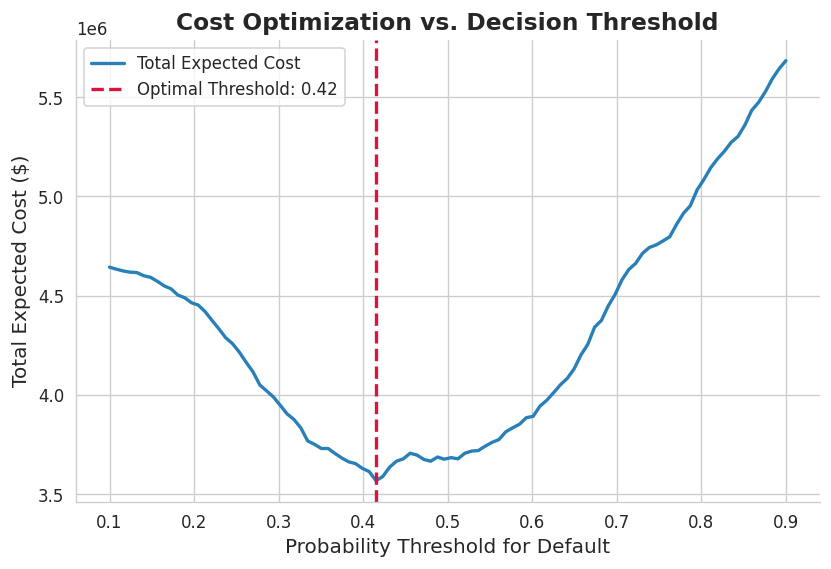

Optimal decision threshold identified at: 0.42


In [3]:
# Define business costs
cost_fn = 5000
cost_fp = 1000

thresholds = np.linspace(0.1, 0.9, 100)
costs = []

for t in thresholds:
    y_pred_t = (y_pred_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]
min_cost = costs[optimal_idx]

# Visualize the Cost Curve
plt.figure(figsize=(8, 5))
plt.plot(thresholds, costs, lw=2, color='#2980B9', label='Total Expected Cost')
plt.axvline(optimal_threshold, color='#DC143C', linestyle='--', lw=2,
            label=f'Optimal Threshold: {optimal_threshold:.2f}')

plt.title('Cost Optimization vs. Decision Threshold')
plt.xlabel('Probability Threshold for Default')
plt.ylabel('Total Expected Cost ($)')
plt.legend()
sns.despine()
plt.show()

print(f"Optimal decision threshold identified at: {optimal_threshold:.2f}")

# Model Explainability
To satisfy regulatory requirements and build trust with business stakeholders, we extract the logistic regression coefficients to interpret the drivers of default risk.

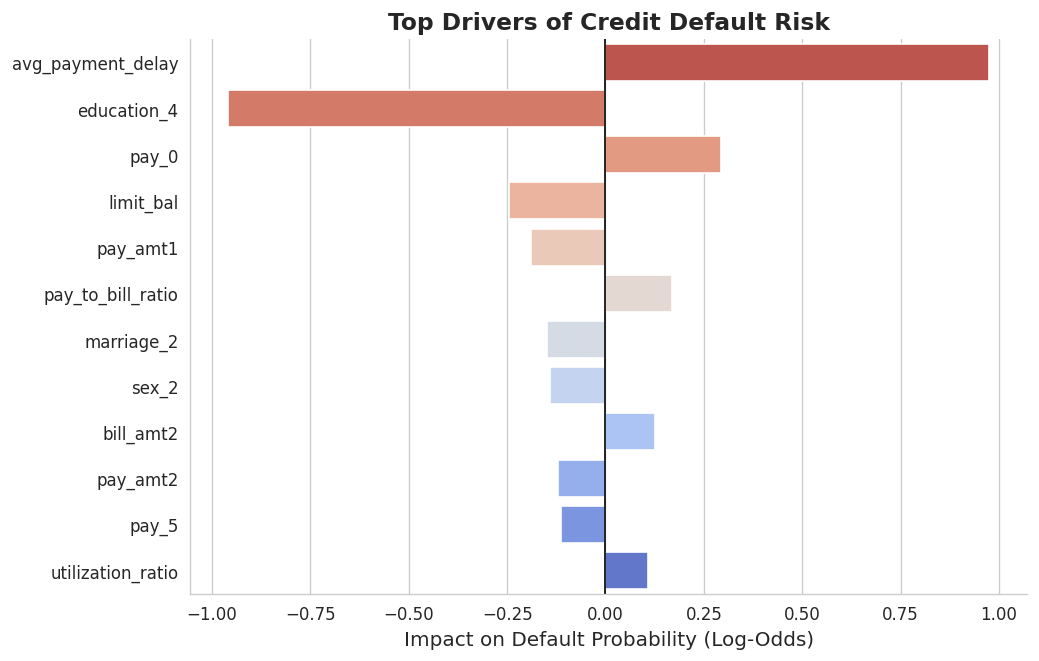

In [4]:
coefficients = log_reg.coef_[0]
feature_names = X_train.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(12)

# Visualize Feature Importance
plt.figure(figsize=(9, 6))
sns.barplot(data=top_features, x='Coefficient', y='Feature', palette="coolwarm_r")

plt.title('Top Drivers of Credit Default Risk')
plt.xlabel('Impact on Default Probability (Log-Odds)')
plt.ylabel('')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

sns.despine()
plt.show()